In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import copy, time
import random
import pickle
import scipy

import timeit
from matplotlib.colors import ListedColormap

import mlrfit as mf
import mfmodel as mfm
import numba as nb

from scipy.sparse import coo_matrix
from scipy.linalg import block_diag, pinvh

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1001)
random.seed(1001)

# True model is MLR factor model with SNR = 4 

Let $\Sigma = FF^T + D$ be MLR. We generate samples using 
$$
y = Fz + e, \qquad z \sim N(0, I), \qquad N(0, D).
$$

In [3]:
mtype = "small_mlr_hier"
n = 100000
signal_to_noise = 4



L = 5

# ranks = np.array([5, 4, 3, 2, 1])
ranks = np.array([30, 20, 10, 5, 1])
rank = ranks.sum()

nsamples = rank * 4
nsamples

264

In [4]:
pi_rows = np.random.permutation(n)
hpart = {'rows':{'pi':pi_rows, 'lk':[]}, 'cols':{'pi':pi_rows, 'lk':[]}} 
for ngroups in [2, 5, 9, 17, n+1]:
       hpart['rows']['lk'] += [ np.linspace(0, n, ngroups, endpoint=True, dtype=int)]
hpart['rows']['lk'][1] = np.delete(hpart['rows']['lk'][1], -2)
hpart['rows']['lk'][2] = np.delete(hpart['rows']['lk'][2], -4)
hpart['cols']['lk'] = hpart['rows']['lk']
part_sizes = mfm.print_hpart_numgroups(hpart)
mfm.valid_hpart(hpart)

level=0, num_groups=1, mean_size=100000.0
level=1, num_groups=3, mean_size=33333.3
level=2, num_groups=7, mean_size=14285.7
level=3, num_groups=16, mean_size=6250.0
level=4, num_groups=100000, mean_size=1.0


In [5]:
F_hpart = {"pi": hpart['rows']["pi"], "lk": hpart['rows']["lk"][:-1]}
true_mfm = mfm.MFModel()
true_mfm = mfm.generate_mfmodel(true_mfm, n, F_hpart, ranks, signal_to_noise, debug=False)
F_hpart["pi_inv"] = true_mfm.pi_inv

signal_var=81.15506713197232, noise_var=16.242432778950498
SNR=3.9964847160793444, signal_to_noise=4


(100000, 240)


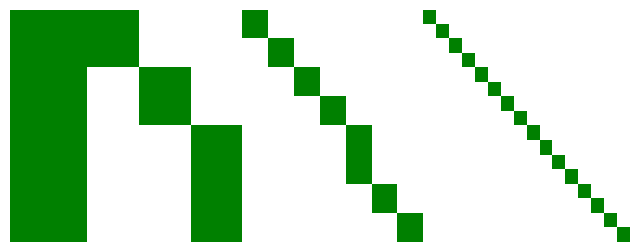

In [6]:
true_sparse_F = mf.convert_compressed_to_sparse(true_mfm.F, 
                                             F_hpart, 
                                             ranks[:-1]).toarray()
print(true_sparse_F.shape)
cmap = ListedColormap(['white', 'green'])
plt.figure(figsize=(8, 3)) 
plt.matshow(true_sparse_F!=0, aspect='auto', fignum=1, cmap=cmap) 
plt.axis('off')
# plt.show()

# Save the figure to a PDF file
plt.savefig('large_F_sparsity.pdf', bbox_inches='tight', pad_inches=0)
# plt.close()
del true_sparse_F

In [7]:
n, true_mfm.num_factors(), L, ranks.sum()

(100000, 240, 5, 66)

In [8]:
v = np.random.randn(n, 1)


hat_x = true_mfm.solve(v, eps=1e-12, max_iter=20, printing=False)
reldiff = np.linalg.norm(true_mfm.matvec(hat_x) - v) / np.linalg.norm(v)
print(f"solve {reldiff=}")

solve reldiff=1.3249785023919495e-12


In [9]:
v = np.random.randn(n, 1)


hat_x = true_mfm.solve(v, eps=1e-9, max_iter=15, printing=False)
reldiff = np.linalg.norm(true_mfm.matvec(hat_x) - v) / np.linalg.norm(v)
print(f"solve {reldiff=}")

solve reldiff=2.2151414634986753e-11


In [10]:
%timeit true_mfm.inv_coefficients()

173 ms ± 13.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%timeit true_mfm.solve(v, eps=1e-9, max_iter=15, printing=False)

37.7 ms ± 19.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
true_mfm.D.min(), true_mfm.D.max()

(0.0006785230567792892, 32.456283388481424)

# EM

In [13]:
C = mfm.sample_data(nsamples, true_mfm)

Z = (C - C.mean(axis=1, keepdims=True))[F_hpart["pi"], :]
# unpermuted_A = (Z @ Z.T / (Z.shape[1]-1))[true_mfm.pi_inv, :][:, true_mfm.pi_inv]

# permute to put clusters on diagonal
Y = Z.T
N = Y.shape[0]

permuted_F_hpart = {"pi_inv":np.arange(n), "pi":np.arange(n), "lk":F_hpart["lk"]}
row_selectors, si_groups, F_hpart, groups_all = mfm.row_col_selections(hpart, return_groups=True)


mfm_Sigma = mfm.MFModel(hpart=F_hpart, ranks=ranks)
mfm_Sigma.init_FD(ranks, F_hpart, init_type="Y", Y=Y)
F0, D0 = mfm_Sigma.F, mfm_Sigma.D

num_levels=5, num_sparsities=16
(16, 4) [ 0  2  6 15]


In [14]:
rank, mfm_Sigma.num_factors()

(66, 240)

In [15]:
loglikelihoods = [-np.inf]
N = Y.shape[0]
eps = 1e-12
for t in range(10):
    F1 = mfm.fast_EM_get_F(F0, D0, Y, ranks, permuted_F_hpart, row_selectors, si_groups)
    D1 = mfm.fast_EM_get_D(F0, D0, F1, Y, ranks, permuted_F_hpart, row_selectors, si_groups)
    F0, D0 = F1, D1
    assert D1.min() >= -1e-8 #and loglikelihoods[-2] - 1e-8 <= loglikelihoods[-1]
    if t % 1 == 0:
        obj = mfm.fast_loglikelihood_value(F0, D0, Y, ranks, permuted_F_hpart, mfm_Sigma.num_factors(),
                                           tol1=1e-5, tol2=1e-5)
        loglikelihoods += [obj]
        print(f"{t=}, {obj=},  {D1.min()=}, {D1.max()=}")


print("PASSED")

t=0, obj=-285766.0809087102,  D1.min()=1.6381208806848133, D1.max()=60.37624034819059
t=1, obj=-275202.6098993925,  D1.min()=0.4500254138608646, D1.max()=44.751520291977684
t=2, obj=-271715.90622412605,  D1.min()=0.20186091191444025, D1.max()=42.7129884509777
t=3, obj=-269591.92534396803,  D1.min()=0.06637629047252797, D1.max()=40.8292433553607
t=4, obj=-268050.39468135167,  D1.min()=0.041810734332626234, D1.max()=39.103901906547755
t=5, obj=-266763.70725099015,  D1.min()=0.041335018643263596, D1.max()=38.33564922158625
t=6, obj=-265550.20964538516,  D1.min()=0.03848673695155082, D1.max()=37.832791868686854
t=7, obj=-264364.2455017644,  D1.min()=0.029475846767230574, D1.max()=37.373709972570964
t=8, obj=-263398.8948664446,  D1.min()=0.020880488714200594, D1.max()=37.13127799279376
t=9, obj=-262693.91525084974,  D1.min()=0.016224932076070356, D1.max()=36.95374576197764
PASSED
